In [255]:
import warnings
warnings.filterwarnings("ignore")

In [256]:
import PIL
import cv2
import re
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [259]:
IMAGE_SIZE = (75, 75, 3)
CLASSES = ['rock', 'paper', 'scissors']

In [260]:
# 0->rock, 1->paper, 2->scissors
train_data_x = []
train_data_y = []
val_data_x = []
val_data_y = []
test_data_x = []
test_data_y = []
folder = 'Rock-Paper-Scissors/train/'
for item in CLASSES:
    for file in os.listdir(os.path.join(folder, item)):
        img = cv2.imread(os.path.join(folder, item, file))
        if(img.shape != IMAGE_SIZE):
            img = cv2.resize(img, IMAGE_SIZE[:2])
        train_data_x.append(img)
        train_data_y.append(item)

folder = 'Rock-Paper-Scissors/validation/'
for file in os.listdir(folder):
    img = cv2.imread(os.path.join(folder, file))
    if(img.shape != IMAGE_SIZE):
        img = cv2.resize(img, IMAGE_SIZE[:2])
    val_data_x.append(img)
    if(re.match(r'rock.*', file)):    val_data_y.append('rock')
    elif(re.match(r'paper.*', file)):    val_data_y.append('paper')
    else:    val_data_y.append('scissors')
        
folder = 'Rock-Paper-Scissors/test/'
for item in CLASSES:
    for file in os.listdir(os.path.join(folder, item)):
        img = cv2.imread(os.path.join(folder, item, file))
        if(img.shape != IMAGE_SIZE):
            img = cv2.resize(img, IMAGE_SIZE[:2])
        test_data_x.append(img)
        test_data_y.append(item)
        
print("No. of training items   = " + str(len(train_data_x)))
print("No. of validation items = " + str(len(val_data_x)))
print("No. of test items       = " + str(len(test_data_x)))

No. of training items   = 2520
No. of validation items = 33
No. of test items       = 372


In [261]:
X_train = np.array(train_data_x, dtype=np.float)
y_train = np.zeros((len(train_data_y), len(CLASSES)), dtype=np.float)
for i in range(len(train_data_y)):
    for j in range(len(CLASSES)):
        if(train_data_y[i]==CLASSES[j]):
            y_train[i][j] = 1
del train_data_x
del train_data_y

X_val = np.array(val_data_x, dtype=np.float)
y_val = np.zeros((len(val_data_y), len(CLASSES)), dtype=np.float)
for i in range(len(val_data_y)):
    for j in range(len(CLASSES)):
        if(val_data_y[i]==CLASSES[j]):
            y_val[i][j] = 1
del val_data_x
del val_data_y

X_test = np.array(test_data_x, dtype=np.float)
y_test = np.zeros((len(test_data_y), len(CLASSES)), dtype=np.float)
for i in range(len(test_data_y)):
    for j in range(len(CLASSES)):
        if(test_data_y[i]==CLASSES[j]):
            y_test[i][j] = 1
del test_data_x
del test_data_y

In [262]:
print("X_train size = " + str(X_train.shape))
print("y_train size = " + str(y_train.shape))
print("X_val size   = " + str(X_val.shape))
print("y_val size   = " + str(y_val.shape))
print("X_test size  = " + str(X_test.shape))
print("y_test size  = " + str(y_test.shape))

X_train size = (2520, 75, 75, 3)
y_train size = (2520, 3)
X_val size   = (33, 75, 75, 3)
y_val size   = (33, 3)
X_test size  = (372, 75, 75, 3)
y_test size  = (372, 3)


In [263]:
scaler = keras.Sequential([keras.layers.experimental.preprocessing.Rescaling(1/255)])

In [264]:
model = keras.Sequential([ scaler,
keras.layers.Conv2D(64,kernel_size=5,strides=1,input_shape=(75, 75, 3),activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Conv2D(64,kernel_size=5,strides=1,activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Conv2D(64,kernel_size=5,strides=1,activation="relu"),
keras.layers.MaxPooling2D(pool_size=(2,2),strides=2),
keras.layers.Flatten(),
keras.layers.Dense(2304,activation="relu"),
keras.layers.Dropout(0.2),
keras.layers.Dense(3,activation="softmax")
])

In [265]:
model.compile(optimizer = tf.keras.optimizers.Adam(),
             loss = tf.keras.losses.CategoricalCrossentropy(),
             metrics = ['accuracy'])

In [266]:
history = model.fit(X_train,y_train,batch_size=128,validation_data=(X_val,y_val),epochs=3)

Epoch 1/3
20/20 [==============================] - 73s 4s/step - loss: 1.0525 - accuracy: 0.4794 - val_loss: 0.8318 - val_accuracy: 0.6667
Epoch 2/3
20/20 [==============================] - 54s 3s/step - loss: 0.4276 - accuracy: 0.8433 - val_loss: 0.4265 - val_accuracy: 0.8788
Epoch 3/3
20/20 [==============================] - 49s 2s/step - loss: 0.0771 - accuracy: 0.9766 - val_loss: 0.3564 - val_accuracy: 0.9394


In [267]:
model.evaluate(X_test,y_test)

12/12 [==============================] - 3s 239ms/step - loss: 0.8618 - accuracy: 0.8737


[0.861767590045929, 0.8736559152603149]

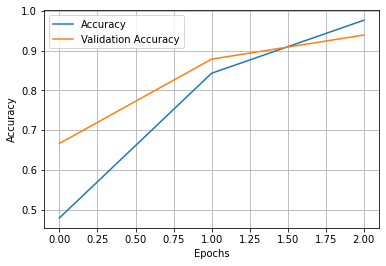

In [268]:
history_df = pd.DataFrame(history.history)
plt.plot(history_df.accuracy,label="Accuracy")
plt.plot(history_df.val_accuracy,label="Validation Accuracy")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.grid()

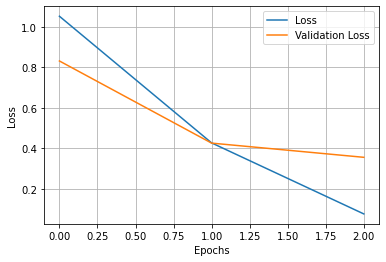

In [269]:
plt.plot(history_df.loss,label="Loss")
plt.plot(history_df.val_loss,label="Validation Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)


In [270]:
y_pred = model.predict(X_test)
y_test=np.argmax(y_test,axis=1)
y_pred=np.argmax(y_pred,axis=1)

12/12 [==============================] - 3s 247ms/step


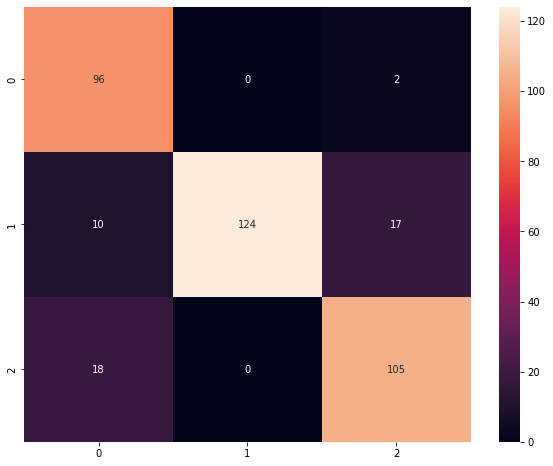

In [276]:
confusion_mtx = confusion_matrix(y_pred,y_test) 
plt.figure(figsize = (10,8))
sns.heatmap(confusion_mtx, annot=True, fmt='d',);